# XGB Classifier

### Imports

In [16]:

# Lets import our necessary libraries
import pandas as pd
import seaborn as sns 
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from xgboost import plot_importance
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

### Data Loading and Cleaning

In [3]:
# Create our list of dataframes containing each dataset
df = pd.read_csv('../Data/dataset83.csv')

# Remove unecessary data
df.drop(['Year_start', 'Year_end'], axis='columns', inplace=True)

# Encode the class data 
label_encoder = LabelEncoder()
df['Species'] = label_encoder.fit_transform(df['Species'])
df['Population'] = label_encoder.fit_transform(df['Population'])
df['Sex'] = label_encoder.fit_transform(df['Sex'])

# Converting a column to float
df['Thorax_length'] = pd.to_numeric(df['Thorax_length'], errors='coerce').astype('float64')

# Converting a column to int (after ensuring it's first converted to float to handle non-integer formats)
df['wing_loading'] = pd.to_numeric(df['wing_loading'], errors='coerce').astype('float64')

for col in df.columns:
    if df[col].dtype == 'float64' or df[col].dtype == 'int64':
        # Fill missing values with mean for numerical columns
        col_mean = df[col].mean()
        df[col] = df[col].fillna(col_mean)
    elif df[col].dtype == 'object':
        # Fill missing values with mode for categorical columns
        col_mode = df[col].mode()[0]
        df[col] = df[col].fillna(col_mode)

### Separte Lables/Features and Normalise/Scale

In [26]:

# Split up features and label
X = df.drop(columns='Sex')
y = df['Sex']

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

0       0
1       1
2       0
3       1
4       0
       ..
1726    1
1727    0
1728    1
1729    0
1730    1
Name: Sex, Length: 1731, dtype: int64


### Perform Train Test Split

In [28]:
# Perform a 90/10 train test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, stratify=y, random_state=420) # Stratify to ensure classes evenly spread

[1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 

### Define and Train Model

In [6]:
# Define the model
model = XGBClassifier(random_state=420)

# Create a pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),  # Ensure scaling is part of the pipeline to prevent data leakage
    ('clf', model)
])

# Setup tuning for the hyperparameters 
search_space = {
    'clf__max_depth': Integer(2, 17),
    'clf__learning_rate': Real(0.001, 1.0, prior='log-uniform'),
    'clf__subsample': Real(0.5, 1.0),
    'clf__colsample_bytree': Real(0.5, 1.0),
    'clf__colsample_bylevel': Real(0.5, 1.0),
    'clf__colsample_bynode': Real(0.5, 1.0),
    'clf__reg_alpha': Real(0.0, 10.0),
    'clf__reg_lambda': Real(0.0, 10.0),
    'clf__gamma': Real(0.0, 10.0),
    'clf__n_estimators': Integer(100, 500)
}
opt = BayesSearchCV(pipe, search_space, cv=10, n_iter=10, scoring='roc_auc', random_state=420)
opt.fit(X_train, y_train)

BayesSearchCV(cv=10,
              estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                        ('clf',
                                         XGBClassifier(base_score=None,
                                                       booster=None,
                                                       callbacks=None,
                                                       colsample_bylevel=None,
                                                       colsample_bynode=None,
                                                       colsample_bytree=None,
                                                       device=None,
                                                       early_stopping_rounds=None,
                                                       enable_categorical=False,
                                                       eval_metric=None,
                                                       feature_types=None,
                                                       gamma=None,
                                                       grow_policy=None,
                                                       importance_type=...
                             'clf__max_depth': Integer(low=2, high=17, prior='uniform', transform='normalize'),
                             'clf__n_estimators': Integer(low=100, high=500, prior='uniform', transform='normalize'),
                             'clf__reg_alpha': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'clf__reg_lambda': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'clf__subsample': Real(low=0.5, high=1.0, prior='uniform', transform='normalize')})

### Best Model Parameters

In [7]:
print(f"Best Estimator: {opt.best_estimator_}\n")

Best Estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=0.9293912411493371,
                               colsample_bynode=0.7898895684191161,
                               colsample_bytree=0.7007188826885055, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=8.269507500638683,
                               grow_pol...e, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.26582794314867314, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=10,
                               max_leaves=None, min_chi

### Best Train and Test Scores

In [8]:
print(f"Best Train Score: {opt.best_score_}\n")
print(f"Test Score: {opt.score(X_test, y_test)}\n")

Best Train Score: 0.9804133211265637

Test Score: 0.9816331923890064



### Predictions and Probabilities of test set

In [9]:
print(f"Predictions: {opt.predict(X_test)}\n")
print(f"Probabilities: {opt.predict_proba(X_test)}\n")

Predictions: [1 1 0 1 1 0 1 0 1 0 1 0 0 0 1 1 1 0 0 0 0 1 1 0 0 0 1 0 1 0 0 0 1 0 0 0 0
 0 1 0 1 0 0 0 1 1 0 0 0 1 1 1 1 1 1 0 0 0 1 1 0 1 1 0 1 0 0 0 1 0 1 0 1 1
 1 0 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 0 1 1 1 1 0 1 1 1
 0 1 1 1 0 1 1 0 1 0 1 0 1 1 0 0 0 1 0 0 0 1 1 1 0 1 0 1 1 0 0 1 1 1 1 0 0
 0 0 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 0 0 1 1 1 0 0 0 1]

Probabilities: [[0.07765228 0.9223477 ]
 [0.1265378  0.8734622 ]
 [0.92615867 0.07384136]
 [0.37070078 0.6292992 ]
 [0.08897322 0.9110268 ]
 [0.90051204 0.09948798]
 [0.08796757 0.9120324 ]
 [0.9615029  0.03849712]
 [0.05115634 0.94884366]
 [0.96168834 0.03831164]
 [0.04124713 0.9587529 ]
 [0.91308194 0.08691807]
 [0.957125   0.04287498]
 [0.957125   0.04287498]
 [0.0770067  0.9229933 ]
 [0.06901538 0.9309846 ]
 [0.16412938 0.8358706 ]
 [0.957125   0.04287498]
 [0.909291   0.09070898]
 [0.9656201  0.03437993]
 [0.5864658  0.41353422]
 [0.04124713 0.9587529 ]
 [0.22416782 0.7758322 ]
 [0.86621714 0.1337829 ]
 [0.9309267  0.06

### Best Classifier Steps

In [10]:
print(f"Steps: {opt.best_estimator_.steps}\n")

Steps: [('scaler', StandardScaler()), ('clf', XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.9293912411493371,
              colsample_bynode=0.7898895684191161,
              colsample_bytree=0.7007188826885055, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=8.269507500638683,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.26582794314867314,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=468, n_jobs=None,
              num_parallel_tree=None, random_state=420, ...))]



### Feature Importances

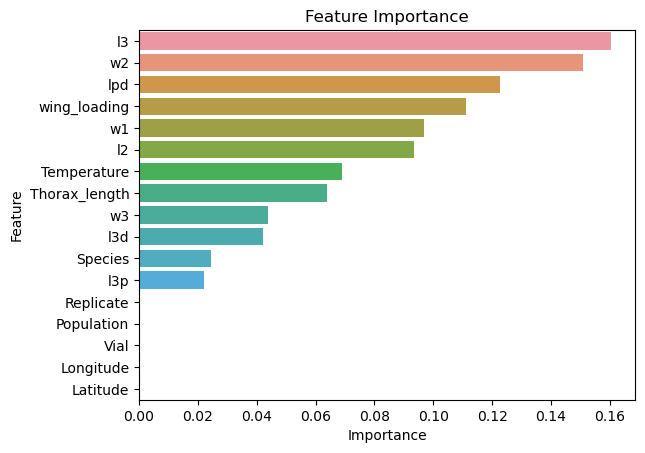

In [14]:
xgboost_model = opt.best_estimator_.named_steps['clf']
importance = pd.DataFrame({'Feature': X.columns, 'Importance': xgboost_model.feature_importances_}).sort_values(by='Importance', ascending=False)
sns.barplot(x='Importance', y='Feature', data=importance)
plt.title('Feature Importance')
plt.show()